### Linear regression 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data generation
First we need to create our x data and y data. We want to find the parameters a and b for the fuction $y = a*x + b $ Our parameters a and b are known, $a = 1.65$ and $b = 3.8$. In addition we add some random noise with mean 0 and standard deviation 8 to the target y.

In [2]:
np.random.seed(seed=22)
N = 50
x_data = (np.linspace(0,50,N)).astype('float32')
y_data = ((1.65 * x_data) + 3.8 + np.random.normal(0,8,N)).astype('float32')

This is the function with and without gaussian noise

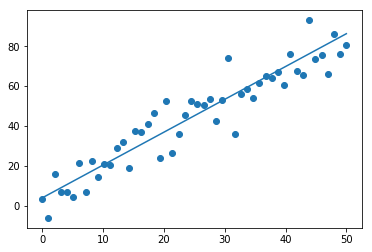

In [3]:
plt.scatter(x_data,y_data)
plt.plot(x_data,(1.65*x_data)+3.8)

### RSS Minimization by trying

Fit a linear function to the data and calculate residual sum of squares (RSS). Play around with the sliders so that the RSS is minimized. As a technical detail, we use the mean instead of the sum to be indpendent of the number of data points.

In [4]:
def linreg(a,b):
    plt.scatter(x_data,y_data)
    plt.plot(x_data,a*x_data+b)
    plt.xlim((-10, 60))
    plt.ylim((-10, 100))
    plt.show()
    print("Loss {}".format(np.mean(np.square(y_data-(a*x_data+b)))))

interact(linreg,a=(-5,5,0.05),b=(-50,50,1))

interactive(children=(FloatSlider(value=0.0, description='a', max=5.0, min=-5.0, step=0.05), IntSlider(value=0, description='b', max=50, min=-50), Output()), _dom_classes=('widget-interact',))

<function __main__.linreg>

### Linear regression in TensorFlow, feeding data  

In [5]:
# Defining the graph (construction phase)
tf.reset_default_graph()
a = tf.Variable(1.0, name = 'a') 
b = tf.Variable(1.0, name = 'b')
x = tf.placeholder('float32', [N], name='x_data')
y = tf.placeholder('float32', [N], name='y_data')
loss = tf.reduce_mean(tf.square(a*x + b - y)) #Average is called reduce_mean

init_op = tf.global_variables_initializer() 
# Initialization ('symbolic'), this creates a new operation in the graph. Which
# initializes the graph. We call this later, when we have a concrete realization of the graph

Now feed your optimal parameters from above through the tensorflow graph and compare the "loss" with the RSS 

In [6]:
# Working with a concrete realization (launching a graph). 
# A session sess is created  with the with construct 
# the session is closed, when moving out of the with class
with tf.Session() as sess: 
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    res = sess.run(loss, feed_dict={x:x_data, y:y_data, a:1.7, b:1.55}) #Evaluation loss using the provided data
    writer = tf.summary.FileWriter("/tmp/linreg", sess.graph) 
    writer.close()
    print("Loss {} (a=1.7, b=1.55)".format(res))

Loss 70.27873229980469 (a=1.7, b=1.55)


### Linear regression with TensorFlow, optimization
Now let tensorflow do the work and find the optimal values for a and b to minimize the loss

In [7]:
train_op = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) #A new activity doing one optimization step 

# when called.
# Other optimizers 
#train_op = tf.train.AdamOptimizer().minimize(loss) 
#train_op = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(loss)

epochs = 5000
results = np.zeros((epochs, 4))
init_op = tf.global_variables_initializer() #Initialization
with tf.Session() as sess:
    sess.run(init_op) #Running the initialization
    for e in range(epochs): #Fitting the data for some epochs
        res = sess.run([train_op, loss, a, b], feed_dict={x:x_data, y:y_data})  
        results[e] = res
        if ((e < 5) | (e > epochs-5)):
            print("Epoch{} Loss {} (a={}, b={})".format(e+1,res[1],res[2],res[3]))
    res = sess.run([loss, a, b], feed_dict={x:x_data, y:y_data})

Epoch1 Loss 479.24163818359375 (a=1.1172491312026978, b=1.003685712814331)
Epoch2 Loss 353.2269592285156 (a=1.2147388458251953, b=1.0067845582962036)
Epoch3 Loss 266.1045227050781 (a=1.2957990169525146, b=1.0093952417373657)
Epoch4 Loss 205.8709716796875 (a=1.3631982803344727, b=1.011600136756897)
Epoch5 Loss 164.22735595703125 (a=1.4192386865615845, b=1.01346755027771)
Epoch4997 Loss 69.34053802490234 (a=1.6692943572998047, b=1.9132964611053467)
Epoch4998 Loss 69.34028625488281 (a=1.6692897081375122, b=1.9134531021118164)
Epoch4999 Loss 69.34002685546875 (a=1.6692850589752197, b=1.9136097431182861)
Epoch5000 Loss 69.33979797363281 (a=1.6692804098129272, b=1.9137663841247559)


In [ ]:
!tensorboard --logdir=/tmp/linreg/